# Multi-Asset Momentum Trading Project

## Objective
The objective of this project is to develop a **multi-asset trading strategy** using **Bollinger Bands**, backtest the portfolio over historical stock data, and evaluate performance metrics such as **Sharpe ratio**, **max drawdown**, and **total return**.

## Dataset
We will use **Yahoo Finance historical stock prices** for selected tickers: AAPL, MSFT, AMZN.

## Approach
1. Fetch stock price data
2. Calculate Bollinger Bands
3. Generate buy/sell signals
4. Backtest portfolio allocation
5. Calculate portfolio metrics
6. Visualize equity curve and stock prices


In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import vectorbt as vbt
import seaborn as sns
sns.set_style("darkgrid")  # Sets Seaborn style globally

## Step 1: Fetch Multi-Stock Data

We will fetch daily **closing prices** for AAPL, MSFT, and AMZN from Yahoo Finance.


/var/folders/vn/h_d59rgj0h37c9x35rbw5br40000gn/T/ipykernel_74484/566362666.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/var/folders/vn/h_d59rgj0h37c9x35rbw5br40000gn/T/ipykernel_74484/566362666.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed
/var/folders/vn/h_d59rgj0h37c9x35rbw5br40000gn/T/ipykernel_74484/566362666.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed

✅ Data successfully fetched!


,AAPL,MSFT,AMZN
Date,,,
2018-01-02,40.381001,79.198311,59.450500
2018-01-03,40.373966,79.566917,60.209999
2018-01-04,40.561497,80.267204,60.479500
2018-01-05,41.023300,81.262367,61.457001
2018-01-08,40.870941,81.345306,62.343498


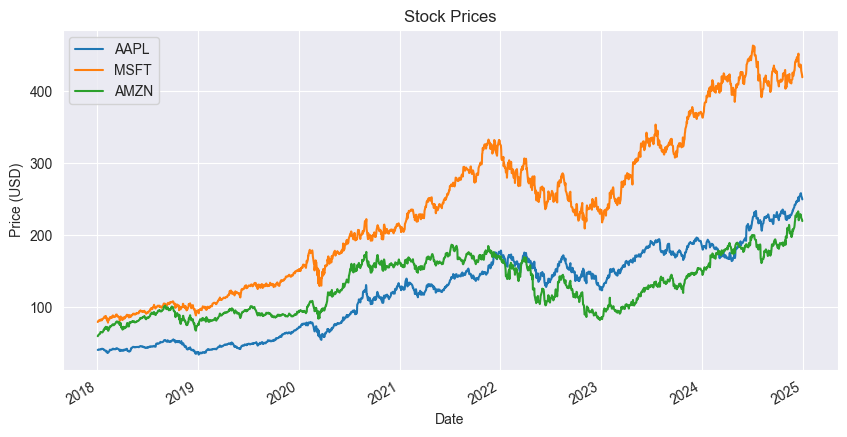

In [2]:
# Define tickers and date range
tickers = ["AAPL", "MSFT", "AMZN"]
start_date = "2018-01-01"
end_date = "2025-01-01"

# Fetch data safely
data = {}
for ticker in tickers:
    print(f"Downloading {ticker}...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:  # Check if data is returned
        data[ticker] = df["Close"]  # Store Close prices only
    else:
        print(f"⚠️ No data returned for {ticker}")

# Combine into a single DataFrame only if we have valid data
if data:
    price_df = pd.concat(data.values(), axis=1)  # Use concat, not dict directly
    price_df.columns = data.keys()  # Rename columns with ticker names
    price_df.dropna(inplace=True)    # Drop missing values
    print("✅ Data successfully fetched!")
    display(price_df.head())
else:
    print("❌ No data fetched for any ticker!")

# Plotting 
if 'price_df' in locals():
    price_df.plot(figsize=(10, 5))
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.grid(True)
    plt.show()


## Step 2: Calculate Bollinger Bands

Bollinger Bands are used to **identify overbought and oversold conditions**:
- Upper Band = MA + 2*STD
- Lower Band = MA - 2*STD


In [3]:
def add_bollinger_bands(df, window=20):
    ma = df.rolling(window).mean()
    std = df.rolling(window).std()
    upper = ma + 2*std
    lower = ma - 2*std
    return ma, upper, lower

ma_df, upper_df, lower_df = add_bollinger_bands(price_df)


## Step 3: Generate Trading Signals

We assign trading signals based on the position of the stock price relative to the Bollinger Bands:

- **Buy (1):** When the stock price falls **below the lower band** → Indicates potential rebound.
- **Sell (-1):** When the stock price rises **above the upper band** → Indicates potential pullback.
- **Hold (0):** When the stock price remains **between the bands** → No action taken.


In [4]:
signals = pd.DataFrame(index=price_df.index, columns=tickers)

for ticker in tickers:
    signals[ticker] = 0
    signals.loc[price_df[ticker] < lower_df[ticker], ticker] = 1
    signals.loc[price_df[ticker] > upper_df[ticker], ticker] = -1

signals.head()


,AAPL,MSFT,AMZN
Date,,,
2018-01-02,0,0,0
2018-01-03,0,0,0
2018-01-04,0,0,0
2018-01-05,0,0,0
2018-01-08,0,0,0


## Step 4: Backtest Portfolio

- Allocate equal capital to each stock  
- Apply **transaction fees**  
- Track portfolio equity over time

In [5]:
initial_capital = 300000
cash = {ticker: initial_capital/len(tickers) for ticker in tickers}
position = {ticker: 0 for ticker in tickers}
fee = 0.0005
portfolio_equity = []

for i in range(len(signals)):
    total_value = 0
    for ticker in tickers:
        price = price_df[ticker].iloc[i]
        signal = signals[ticker].iloc[i]

        if signal == 1 and cash[ticker] > 0:
            shares = cash[ticker] // price
            cash[ticker] -= shares * price * (1 + fee)
            position[ticker] += shares
        elif signal == -1 and position[ticker] > 0:
            cash[ticker] += position[ticker] * price * (1 - fee)
            position[ticker] = 0

        total_value += cash[ticker] + position[ticker]*price
    portfolio_equity.append(total_value)

portfolio_df = pd.DataFrame({'Equity': portfolio_equity}, index=signals.index)
portfolio_df['Returns'] = portfolio_df['Equity'].pct_change().fillna(0)
portfolio_df.head(50) 

,Equity,Returns
Date,,
2018-01-02,300000.000000,0.000000
2018-01-03,300000.000000,0.000000
2018-01-04,300000.000000,0.000000
2018-01-05,300000.000000,0.000000
2018-01-08,300000.000000,0.000000
2018-01-09,300000.000000,0.000000
2018-01-10,300000.000000,0.000000
2018-01-11,300000.000000,0.000000
2018-01-12,300000.000000,0.000000


## Step 5: Calculate Portfolio Metrics

We will calculate **Sharpe ratio**, **Calmar Ratio**, **Omega Ratio**, **Sortino Ratio**, **max drawdown**, **total return**, and so on by using `vectorbt`.


In [6]:
portfolio = vbt.Portfolio.from_signals(
    close=price_df,
    entries=signals == 1,
    exits=signals == -1,
    init_cash=initial_capital,
    fees=fee,
    freq='1D'
)

stats = portfolio.stats()
print(stats)  # check exact keys

total_return = stats['Total Return [%]']
sharpe = stats.get('Sharpe Ratio (ann.)', 0)
max_dd = stats['Max Drawdown [%]']

print(f"Total Portfolio Return: {total_return:.2f}%")
print(f"Portfolio Sharpe Ratio: {sharpe:.2f}")
print(f"Portfolio Max Drawdown: {max_dd:.2f}%")

Start                                2018-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1761 days 00:00:00
Start Value                                     300000.0
End Value                                  625126.195275
Total Return [%]                              108.375398
Benchmark Return [%]                          405.426336
Max Gross Exposure [%]                             100.0
Total Fees Paid                              8157.954064
Max Drawdown [%]                               38.738523
Max Drawdown Duration                  612 days 00:00:00
Total Trades                                   17.333333
Total Closed Trades                                 17.0
Total Open Trades                               0.333333
Open Trade PnL                               -125.572506
Win Rate [%]                                   78.417613
Best Trade [%]                                 21.508189
Worst Trade [%]                

/var/folders/vn/h_d59rgj0h37c9x35rbw5br40000gn/T/ipykernel_74484/1962700620.py:10: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x1046034c0>. Pass column to select a single column/group.



## Step 6: Visualize Portfolio Equity

- Equity curve over time
- Interactive plot with individual stock prices


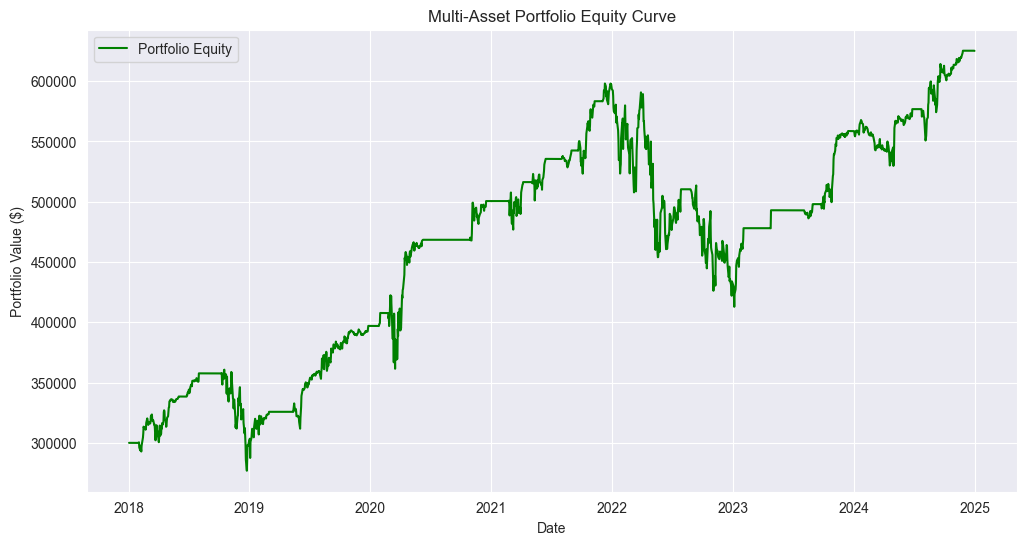

In [7]:
# Static Plot
plt.figure(figsize=(12,6))
plt.plot(portfolio_df['Equity'], label='Portfolio Equity', color='green')
plt.title('Multi-Asset Portfolio Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Interactive Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_df.index, y=portfolio_df['Equity'], name='Portfolio Equity'))
for ticker in tickers:
    fig.add_trace(go.Scatter(x=price_df.index, y=price_df[ticker], name=ticker, yaxis='y2'))
fig.update_layout(
    title='Portfolio Equity vs Stock Prices',
    yaxis=dict(title='Portfolio Value ($)'),
    yaxis2=dict(title='Stock Price ($)', overlaying='y', side='right'),
    legend=dict(x=0.1, y=1.1)
)
fig.show()


## Conclusion

- This notebook demonstrates a **multi-asset momentum strategy** using Bollinger Bands.  
- Portfolio metrics and equity curves allow evaluating **risk-adjusted performance**.  
- The notebook is fully reproducible using **Python 3.13 + Jupyter Notebook**.


## Thank you!